# Model based drift detection (3rd February 2022)

## Introduction

The idea is to remove the Y labels from the training data set and label half of the training data as zero and the other half as one.<br>
A machine learning model is fit on the modified data set and the test data is evaluated and their probabilities of prediction are taken.<br>
If the probability of prediction is between .4 and 6, we consider that the model cannot differentiate between the two data points and that there is no significant drift in the incoming data. If this is not the case, we will infer that there is drift.

In [ ]:
#imports
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

In [ ]:
#loading the data set
df=pd.read_csv("uw-drift-dataset.csv")
df.head()

,feat_nest_active,feat_disaster_recovery,feat_is_bouncing_alarm,feat_alarms_cleared_oss,feat_alarms_cleared,feat_alarms_cleared_power_alarms,feat_alarms_cleared_hw_router_alarms,feat_is_chronic_issue,feat_is_chronic_issue_type2,feat_is_maintenance,feat_is_power_alarms,feat_is_bouncing_ticket,feat_is_hw_radio_alarms,feat_is_hw_bb_alarms,feat_is_hw_pdu_alarms,feat_is_hw_router_alarms,feat_is_sw_alarms,feat_is_reset_list_alarms,feat_sector_down_rt,feat_site_down_rt,feat_sector_down,feat_site_down,feat_layer_l2100_down,feat_layer_l1900_down,feat_layer_l700_down,feat_layer_l600_down,feat_layer_laws_down,feat_layer_u2100_down,feat_layer_u1900_down,feat_layer_g1900_down,feat_chronic_alarm,feat_batch_is_bouncing_alarm,feat_chronic_is_power_alarms,feat_chronic_is_hw_radio_alarms,feat_chronic_is_hw_bb_alarms,feat_chronic_is_hw_pdu_alarms,feat_chronic_is_hw_router_alarms,feat_chronic_is_software_alarms,feat_chronic_is_reset_list_alarms,feat_reset_recent,...,feat_sector_lacks_coverage_layer,feat_all_lte_layers_used,feat_cell_footprint_too_spread_persistent,feat_high_pathloss_persistent,feat_high_pdcch_load_persistent,feat_indoor_traffic_persistent,feat_isolated_site_persistent,feat_number_of_connected_users_persistent,feat_high_cce_usage_old,feat_high_percentage_samples_low_sinr_rate_persistent,feat_low_5MHz_user_throughput_persistent,feat_low_dl_order_modulations_usage_persistent,feat_coverage_trigger_handovers_persistent,feat_ues_on_high_ul_power_persistent,feat_voice_drop_cell_weekday_anomaly,feat_voice_drop_site_weekday_anomaly,feat_interference_trigger_handovers_persistent,feat_alarms_recent,feat_drops_cell_bouncing,feat_drops_transport_issue,feat_volte_drops_mme,feat_drop_ue_lost,feat_overshooting_anomaly,feat_drops_ho_execution_issue,feat_ncell_availability,feat_ho_topoff_ncell,feat_volte_ho_topoff_ncell,feat_ping_pong_ho_ncell,feat_power_degradation_alarm,feat_antenna_hw_alarms,feat_ho_sr_anomaly,feat_cell_bouncing_recent,feat_volte_drops_mme_recent,feat_drops_cell_bouncing_recent,feat_drops_transport_recent,feat_cell_downtime_recent,feat_cell_availability_recent,feat_ncell_availability_recent,feat_cell_edge_ta_anomaly,ground_truth
0,-1,-1,-1,-1,-1,-1,-1,0,0,-1,1,-1,-1,2,0,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,0,2,0,1,0,-1,0,-1,2,-1,-1,-1,2,2,0,-1,1,-1,0,-1,0,2,-1,2,1,0,2,2,1,1,2,-1,1,2,0,0,CELL_BOUNCING|ONGOING|ONGOING_CELL_BOUNCING_TR...
1,-1,-1,0,-1,-1,-1,-1,0,0,-1,2,0,1,1,1,2,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,2,1,2,-1,1,-1,-1,-1,0,2,1,0,0,2,1,1,0,0,1,-1,0,-1,0,-1,1,1,0,2,1,2,0,-1,0,-1,2,2,-1,-1,CELL_BOUNCING|ONGOING|ONGOING_CELL_BOUNCING_TR...
2,-1,-1,-1,-1,-1,-1,-1,0,0,0,2,0,0,0,2,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,...,1,2,2,1,2,0,1,1,1,-1,1,0,2,0,1,2,2,-1,-1,2,-1,-1,-1,-1,-1,2,2,2,-1,2,1,1,0,0,-1,-1,2,2,1,CELL_BOUNCING|ONGOING|ONGOING_CELL_BOUNCING_TR...
3,-1,-1,0,-1,-1,-1,-1,0,-1,0,0,-1,1,-1,1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,0,...,0,0,1,-1,2,-1,1,1,1,0,2,0,2,0,0,1,2,-1,-1,1,-1,-1,0,0,-1,1,1,0,1,1,0,0,-1,-1,2,0,2,-1,-1,CELL_BOUNCING|ONGOING|ONGOING_CELL_BOUNCING_TR...
4,-1,-1,0,-1,-1,-1,-1,0,0,0,2,0,-1,2,-1,0,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,2,-1,1,2,-1,-1,-1,-1,-1,2,-1,0,-1,2,1,1,1,-1,-1,2,0,0,-1,0,2,1,2,2,1,-1,2,0,-1,1,1,0,2,0,2,CELL_BOUNCING|ONGOING|ONGOING_CELL_BOUNCING_TR...


In [ ]:
# dropping the y label which we are not using
df.shape
df_dropped=df.drop("ground_truth",axis=1)

In [ ]:
# Selecting the number of items for the training set
number_of_items_in_train_set=10000

In [ ]:
# Setting y labels of half of the train labels to be one and the other half to be 0
train_dataset=df_dropped[:number_of_items_in_train_set]
test_dataset=df_dropped[number_of_items_in_train_set:]

a=train_dataset.iloc[number_of_items_in_train_set//2:]
b=train_dataset.iloc[:number_of_items_in_train_set//2]
a["ground_truth"]=0
b["ground_truth"]=1

new_train_dataset=a.append(b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
new_train_dataset["ground_truth"]

5000    0
5001    0
5002    0
5003    0
5004    0
       ..
4995    1
4996    1
4997    1
4998    1
4999    1
Name: ground_truth, Length: 10000, dtype: int64

In [ ]:
# assigning the X&Y variables of the new data set
y=new_train_dataset["ground_truth"]
X=new_train_dataset.drop(["ground_truth"],axis=1)


In [ ]:
# implementing train test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
 

In [ ]:
# fitting a random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_val)

y_true=y_val
from sklearn.metrics import f1_score
f1=f1_score(y_true, y_pred, average='macro')
f1 

0.9596750149829048

In [ ]:
# finding the probability of prediction on testing data
test_df=test_dataset
prob_range=.2  # probability range should not be greater than .5
prob_df=pd.DataFrame(clf.predict_proba(test_df.iloc[:,:]))
print("Shape of the probability array is: " ,prob_df.shape)
print("Shape of the testing dataframe is: " ,test_df.shape)

# finding number of items within a specific probability range
prob_df_in_range=prob_df.loc[(prob_df[0]>.5-prob_range) & (prob_df[0]<(.5+prob_range))]
print("Number of items with probability within ",.5-prob_range," and ",.5+prob_range," is: " ,prob_df_in_range.shape)
percentage_prob_df_in_range=prob_df_in_range.shape[0]*100/prob_df.shape[0]
print("percentage of items in the probability range= ", percentage_prob_df_in_range)

Shape of the probability array is:  (53425, 2)
Shape of the testing dataframe is:  (53425, 133)
Number of items with probability within  0.3  and  0.7  is:  (31115, 2)
percentage of items in the probability range=  58.24052409920449


Conclusion- we could not conclude that this test works well for drift dictation because the current data set is tested for drift detection and it does not have it. But 58% of the samples are only predicted with low probability. This could mean that the other 42% if having drift. But that is not the case.<br>
because of this, we are not using this method

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


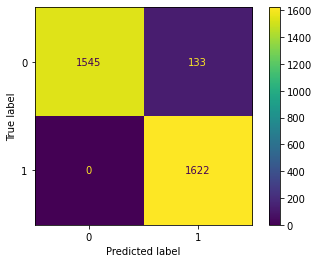

In [ ]:
# plotting confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_val, y_val)
 

In [ ]:
#TODO: test using chi square test to see if the outlying samples are statistically almost the same distribution
#TODO: test with some other dataset where drift is already exisiting and test the assumptions